In [1]:
import pandas as pd
import numpy as np
import sys
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import json
from os.path import expanduser
import pickle
import random

In [2]:
run_name = 'P3856_YHE211_1_Slot1-1_1_5104'
experiment_name = 'P3856'

EXPERIMENT_DIR = '/media/big-ssd/experiments/{}'.format(experiment_name)

# RESULTS_DIR = '/media/big-ssd/results-P3856'
# IDENTS_PASEF_DIR = '{}/P3856-results-cs-true-fmdw-true-2021-05-20-02-44-34/identifications-pasef'.format(RESULTS_DIR)

IDENTS_PASEF_DIR = '{}/identifications-pasef'.format(EXPERIMENT_DIR)
IDENTS_PASEF_FILE = '{}/exp-{}-identifications-pasef-recalibrated.pkl'.format(IDENTS_PASEF_DIR, experiment_name)

FEATURES_PASEF_DIR = '{}/features-pasef'.format(EXPERIMENT_DIR)
FEATURES_PASEF_FILE = '{}/exp-{}-run-{}-features-pasef-dedup.pkl'.format(FEATURES_PASEF_DIR, experiment_name, run_name)

In [3]:
# define a straight line to exclude the charge-1 cloud
def scan_coords_for_single_charge_region(mz_lower, mz_upper):
    scan_for_mz_lower = max(int(-1 * ((1.2 * mz_lower) - 1252)), 0)
    scan_for_mz_upper = max(int(-1 * ((1.2 * mz_upper) - 1252)), 0)
    return {'scan_for_mz_lower':scan_for_mz_lower, 'scan_for_mz_upper':scan_for_mz_upper}

#### identified features

In [4]:
# load the features identified
with open(IDENTS_PASEF_FILE, 'rb') as handle:
    d = pickle.load(handle)
idents_df = d['identifications_df']

In [5]:
idents_df['excluded'] = idents_df.apply(lambda row: row.scan_apex < scan_coords_for_single_charge_region(row.monoisotopic_mz, row.monoisotopic_mz)['scan_for_mz_lower'], axis=1)
idents_df = idents_df[(idents_df.excluded == False)]

In [6]:
print('{} identifications'.format(len(idents_df)))

37251 identifications


#### detected features

In [7]:
# load the features detected by PASEF
with open(FEATURES_PASEF_FILE, 'rb') as handle:
    d = pickle.load(handle)
features_df = d['features_df']

In [8]:
features_df['excluded'] = features_df.apply(lambda row: row.scan_apex < scan_coords_for_single_charge_region(row.monoisotopic_mz, row.monoisotopic_mz)['scan_for_mz_lower'], axis=1)
features_df = features_df[(features_df.excluded == False)]

In [9]:
print('{} features detected'.format(len(features_df)))

73311 features detected


In [10]:
sets_d = {'detected':set(), 'identified':set()}

In [11]:
sets_d['detected'] = set(features_df.feature_id.tolist())
sets_d['identified'] = set(idents_df.feature_id.tolist())

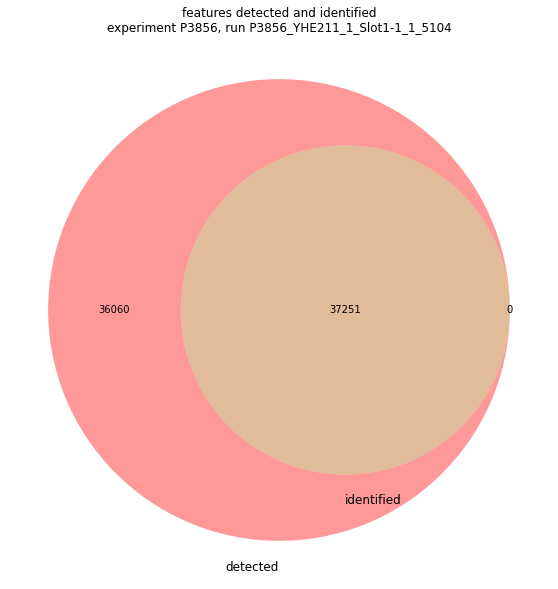

In [12]:
import matplotlib.pyplot as plt
from matplotlib_venn import venn2

f, ax1 = plt.subplots()
f.set_figheight(10)
f.set_figwidth(15)

plt.margins(0.06)
plt.title('features detected and identified\nexperiment {}, run {}'.format(experiment_name, run_name))

venn2([sets_d['detected'],sets_d['identified']], ('detected','identified'))

plt.show()

#### build the training set

In [13]:
# features detected but not identified
features_not_identified = sets_d['detected'] - sets_d['identified']
features_identified = sets_d['identified']

In [14]:
len(features_not_identified), len(features_identified)

(36060, 37251)

In [15]:
features_not_identified_df = features_df[features_df.feature_id.isin(features_not_identified)]
features_identified_df = features_df[features_df.feature_id.isin(features_identified)]

In [16]:
SAMPLE_SIZE = 35000

In [17]:
features_not_identified_df = features_not_identified_df.sample(n=SAMPLE_SIZE)
features_not_identified_df['category'] = 0

features_identified_df = features_identified_df.sample(n=SAMPLE_SIZE)
features_identified_df['category'] = 1

In [18]:
combined_df = pd.concat([features_not_identified_df, features_identified_df], axis=0, sort=False, ignore_index=True)

In [19]:
combined_df.fillna(0, inplace=True)

In [20]:
feature_ids_l = combined_df.feature_id.tolist()

In [21]:
train_proportion = 0.8
val_proportion = 0.1

In [22]:
train_n = round(len(feature_ids_l) * train_proportion)
val_n = round(len(feature_ids_l) * val_proportion)

In [24]:
train_set = random.sample(feature_ids_l, train_n)
val_test_set = list(set(feature_ids_l) - set(train_set))
val_set = random.sample(val_test_set, val_n)
test_set = list(set(val_test_set) - set(val_set))

In [25]:
train_df = combined_df[combined_df.feature_id.isin(train_set)]
valid_df = combined_df[combined_df.feature_id.isin(val_set)]
test_df = combined_df[combined_df.feature_id.isin(test_set)]

In [26]:
print('train: {} ({}%), validation: {} ({}%), test: {} ({}%)'.format(len(train_df), round(len(train_df)/len(combined_df)*100), len(test_df), round(len(test_df)/len(combined_df)*100), len(valid_df), round(len(valid_df)/len(combined_df)*100)))


train: 56000 (80%), validation: 7000 (10%), test: 7000 (10%)


In [27]:
input_names = ['deconvolution_score','coelution_coefficient','mobility_coefficient','isotope_count']

In [28]:
X_train = train_df[input_names].to_numpy()
y_train = train_df[['category']].to_numpy()[:,0]

In [29]:
X_valid = valid_df[input_names].to_numpy()
y_valid = valid_df[['category']].to_numpy()[:,0]

In [30]:
X_test = test_df[input_names].to_numpy()
y_test = test_df[['category']].to_numpy()[:,0]

In [37]:
import tensorflow as tf
from tensorflow import keras
from keras.models import Sequential
from keras.layers import Dense, BatchNormalization, Dropout
from tensorflow.keras import layers
from tensorflow.keras.layers.experimental import preprocessing

In [38]:
# define the keras model
model = Sequential()
model.add(BatchNormalization(input_shape=(4,)))
model.add(Dense(100, activation='relu'))
model.add(Dropout(0.2))
model.add(BatchNormalization())
model.add(Dense(100, activation='relu'))
model.add(Dropout(0.2))
model.add(BatchNormalization())
model.add(Dense(100, activation='relu'))
model.add(Dropout(0.2))
model.add(BatchNormalization())
model.add(Dense(1, activation='sigmoid'))

In [39]:
# compile the keras model
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['binary_accuracy'])

In [40]:
# fit the keras model on the dataset
history = model.fit(X_train, 
                    y_train, 
                    validation_data=(X_valid, y_valid),
                    epochs=4000, 
                    batch_size=512,
                    verbose=0)

best validation loss: 0.6594
best validation accuracy: 0.6067


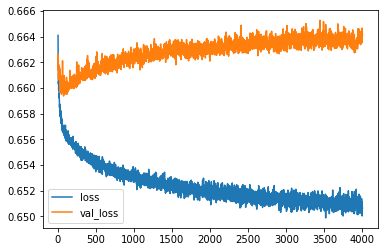

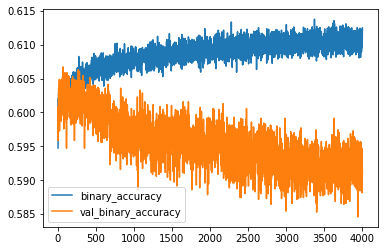

In [41]:
history_df = pd.DataFrame(history.history)
history_df.loc[5:, ['loss', 'val_loss']].plot()
history_df.loc[5:, ['binary_accuracy', 'val_binary_accuracy']].plot()
print(("best validation loss: {:0.4f}"+"\nbest validation accuracy: {:0.4f}").format(history_df['val_loss'].min(), history_df['val_binary_accuracy'].max()))